### refining simplified data classifier
#### using 3 timesteps

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

In [2]:
planets = pd.read_csv('3ts.csv', skipinitialspace=True)
print(planets.columns)

Index(['run', 'planet', 'initial e', 'final e', 'mean e', 'min e', 'max e',
       'sd e', 'initial pericenter', 'final pericenter', 'mean pericenter',
       'min pericenter', 'max pericenter', 'sd pericenter', 'initial jacobi',
       'final jacobi', 'mean jacobi', 'min jacobi', 'max jacobi', 'sd jacobi',
       'initial mhr1', 'final mhr1', 'mean mhr1', 'min mhr1', 'max mhr1',
       'sd mhr1', 'initial mhr2', 'final mhr2', 'mean mhr2', 'min mhr2',
       'max mhr2', 'sd mhr2', 'initial a1_ratio', 'final a1_ratio',
       'mean a1_ratio', 'min a1_ratio', 'max a1_ratio', 'sd a1_ratio',
       'initial a2_ratio', 'final a2_ratio', 'mean a2_ratio', 'min a2_ratio',
       'max a2_ratio', 'sd a2_ratio', 'initial mass1_ratio',
       'final mass1_ratio', 'mean mass1_ratio', 'min mass1_ratio',
       'max mass1_ratio', 'sd mass1_ratio', 'initial mass2_ratio',
       'final mass2_ratio', 'mean mass2_ratio', 'min mass2_ratio',
       'max mass2_ratio', 'sd mass2_ratio', 'end time', 'fate'],


###### started at ~84% accurate

In [3]:
fates = list(set(planets['fate']))

types = {fates[i] : i for i in range(len(fates))}

classes = []

for i in range(len(planets['fate'])):
    if planets['fate'][i] == "remaining":
        classes += [0]
    else:
        classes += [1]
        
classes = np.array(classes)

###### Training

In [126]:
features_train, features_test, classes_train, classes_test = train_test_split(planets, classes, test_size=0.3, random_state=7)

ru = features_test['run'].to_numpy()
p = features_test['planet'].to_numpy()
e = features_test['end time'].to_numpy()
fa = features_test['fate'].to_numpy()

# for graphs
me = features_test['min e'].to_numpy()
fa2 = features_test['final a2_ratio'].to_numpy()
mm2 = features_test['min mass2_ratio'].to_numpy()

d = ['run', 'planet', 'fate', 'end time']

var = ['e','mhr1','mhr2','a1_ratio','a2_ratio','mass1_ratio','mass2_ratio','pericenter','jacobi',]

for v in var:
#     d.append('initial ' + str(v))
    d.append('final ' + str(v))
#     d.append('mean ' + str(v))     # getting rid of mean and sd have similar accuracy results
    d.append('min ' + str(v))
#     d.append('max ' + str(v))
    d.append('sd ' + str(v))
    

ids_train = features_train['planet'].to_numpy()
features_train.drop(d, axis=1, inplace=True)

cols = features_train.columns
features_train = features_train.to_numpy()

ids_test = features_test['planet'].to_numpy()
features_test.drop(d, axis=1, inplace=True)
features_test = features_test.to_numpy()

In [9]:
classifier = GradientBoostingClassifier(random_state=7)
classifier.fit(features_train, classes_train)

GradientBoostingClassifier(random_state=7)

In [48]:
classes_predict = classifier.predict( features_test )
print('Classifier is ', accuracy_score(classes_test, classes_predict) * 100, '% accurate on testing set' )

Classifier is  82.66666666666667 % accurate on testing set


###### refine hyperparameters (grid search)

In [5]:
param_grid = {'learning_rate': [0.05, 0.07, 0.1, 0.12, 0.15],
              'max_depth': [4, 5, 6, 7, 8],
              'n_estimators': [50, 55, 60, 65, 70, 75, 80, 85, 90],
              'max_features': ['auto','sqrt','log2']}  
  
grid = GridSearchCV(GradientBoostingClassifier(), param_grid, refit = True, verbose = 1, n_jobs=-1) 
  
# fitting the model for grid search 
grid.fit(features_train, classes_train)

# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(features_train)
  
# print classification report 
print(classification_report(classes_train, grid_predictions)) 

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed: 12.9min finished


{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 75}
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       232
           1       0.93      0.98      0.96       468

    accuracy                           0.94       700
   macro avg       0.94      0.92      0.93       700
weighted avg       0.94      0.94      0.94       700



In [5]:
classifier = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 4, max_features = 'auto', n_estimators = 75, random_state=7)
classifier.fit(features_train, classes_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features='auto',
                           n_estimators=75, random_state=7)

In [6]:
classes_predict = classifier.predict(features_test)
print('Classifier is ', accuracy_score(classes_test, classes_predict) * 100, '% accurate on testing set' )

Classifier is  86.0 % accurate on testing set




###### feature importances

In [7]:
feats=classifier.feature_importances_
inds=np.argsort(feats)[::-1]

for i in range(len(inds)):
    print(cols[inds[i]], feats[inds[i]])

initial a2_ratio 0.2115211115842252
max mass2_ratio 0.12816747778762438
max e 0.11018980776445347
initial mass2_ratio 0.0876543694728483
initial jacobi 0.06600169373034305
mean mass2_ratio 0.06052005286022682
initial e 0.05457568530026466
max mass1_ratio 0.03672307237807971
initial mass1_ratio 0.034883230751649334
initial a1_ratio 0.02517826216947946
mean mass1_ratio 0.023597712547924112
mean a2_ratio 0.021255565916284743
max a1_ratio 0.020333982557750315
max mhr2 0.019483564693945302
max a2_ratio 0.01726241953206795
mean e 0.013052774085238385
mean a1_ratio 0.01208670139370233
max mhr1 0.008397600697260924
mean mhr1 0.008252130030106436
initial mhr2 0.008036462739317591
mean pericenter 0.007631800276239317
mean jacobi 0.005880582441533343
initial mhr1 0.004916474207212721
max pericenter 0.00461834522299314
max jacobi 0.004126550400733059
initial pericenter 0.0028904500629309405
mean mhr2 0.0027621193955649818


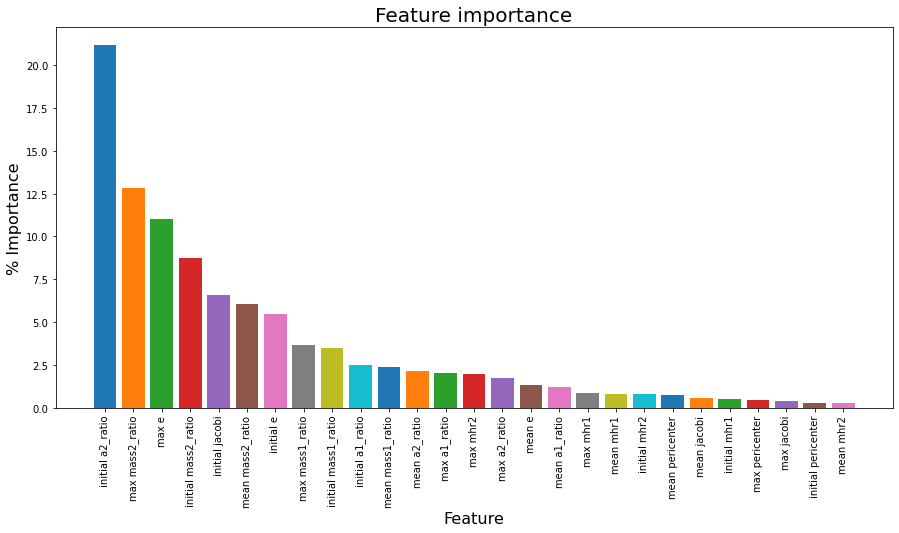

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pylab


f=plt.figure(figsize=(15,7))

for i in range(len(inds)):
    plt.bar(cols[inds[i]], feats[inds[i]] * 100)
    

 
plt.ylabel('% Importance', size=16)
plt.xlabel('Feature', size=16)
plt.title('Feature importance', size=20)
plt.xticks(rotation = 90)
plt.show()

###### playing around with important features - correctly classified vs misclassified planets

1. Maybe revisit the data generation step to try to find the two dynamically closest planets instead of the inner and outer planets in your data set? 
2. Begin to explore the misclassified objects:
    - What are the instability times for misclassified planets?
    - Does the evolution of misclassified planets look different (e.g., does something like a vs. time or e vs. time give us any insight?)
    - (For instance, I might guess that most of the misclassified planets are truly unstable but classified as stable and have long instability times)
3. Look at the probabilities of class membership (how sure are we that planets are stable or unstable)
    - You can use the classifier method predict_proba (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.predict_proba)
    - Do the misclassified objects have high or low probabilities?
    - How many of the correctly classified objects have high probability? (more than 90%? 95%? 99.9%?)
    - What is probability as a function of instability time for the unstable planets?

In [ ]:
stable_x = []
unstable_x = []
misclassified_x = []
stable_y = []
unstable_y = []
misclassified_y = []
    
    
f=plt.figure(figsize=(15,7))

for i in range(len(features_test)):
    if (classes_test[i] == 0 and classes_predict[i] == 0):
        stable_x.append(features_test[i][18])
        stable_y.append(features_test[i][26])
    elif (classes_test[i] == 1 and classes_predict[i] == 1):
        unstable_x.append(features_test[i][18])
        unstable_y.append(features_test[i][26])
    else:
        misclassified_x.append(features_test[i][18])
        misclassified_y.append(features_test[i][26])

        
plt.scatter(stable_x, stable_y, color = 'thistle')
plt.scatter(misclassified_x, misclassified_y, color = 'firebrick', zorder = 2)
plt.scatter(unstable_x, unstable_y, color = 'lightsteelblue')

        
plt.ylabel('max mass2 ratio (2)')
plt.xlabel('initial a2 ratio (1)')
plt.title('initial a2 vs mass2')

Text(0.5, 1.0, 'initial a2 vs mass2')

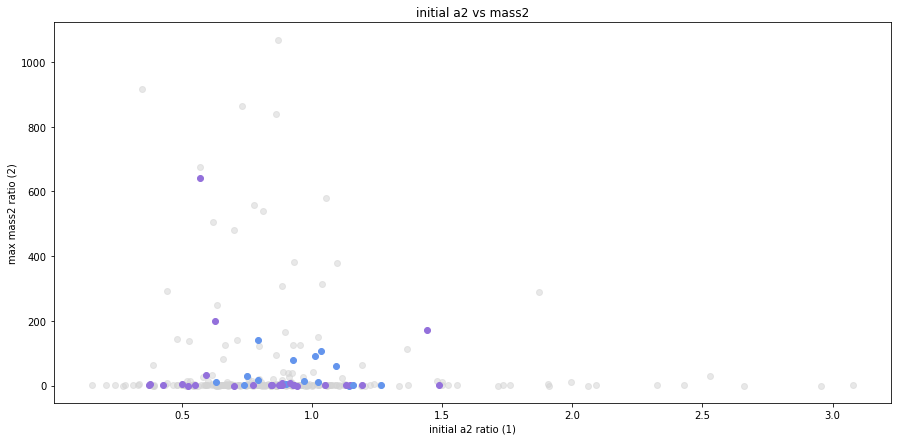

In [119]:
f=plt.figure(figsize=(15,7))

for i in range(0,len(features_test)):
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):    # is actually stable
            plt.scatter(features_test[i][18], features_test[i][26], color = 'mediumpurple', zorder = 3)
        else:                         # is actually unstable
            plt.scatter(features_test[i][18], features_test[i][26], color = 'cornflowerblue', zorder = 3)
    else:                             # correct
        plt.scatter(features_test[i][18], features_test[i][26], color = 'lightgray', alpha=0.5)
        
plt.xlabel('initial a2 ratio (1)')
plt.ylabel('max mass2 ratio (2)')
plt.title('initial a2 vs mass2')

Text(0.5, 1.0, 'initial vs final a2')

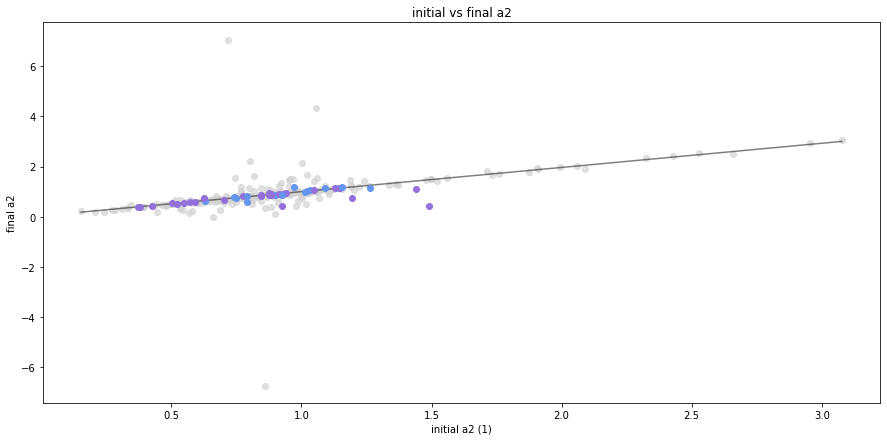

In [139]:
f=plt.figure(figsize=(15,7))

x = []
y = []

for i in range(0,len(features_test)):
    x.append(features_test[i][18])
    y.append(fa2[i])
    
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):    # is actually stable
            plt.scatter(features_test[i][18], fa2[i], color = 'mediumpurple', zorder = 5)
        else:  # is actually unstable
            plt.scatter(features_test[i][18], fa2[i], color = 'cornflowerblue', zorder = 5)
    else:
        plt.scatter(features_test[i][18], fa2[i], color = 'lightgray', alpha=0.7)
        
        
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha = 0.5)


plt.xlabel('initial a2 (1)')
plt.ylabel('final a2')
plt.title('initial vs final a2')

Text(0.5, 1.0, 'min vs max mass2')

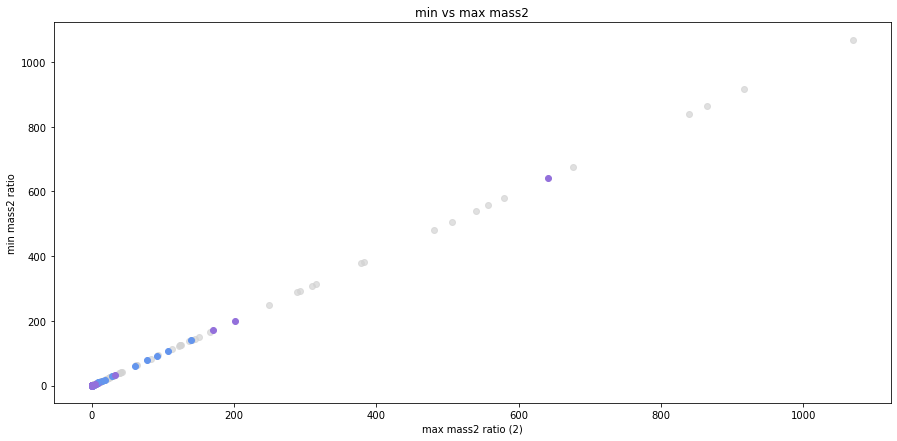

In [142]:
f=plt.figure(figsize=(15,7))

x = []
y = []

for i in range(0,len(features_test)):
    x.append(features_test[i][26])
    y.append(mm2[i])
    
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):    # is actually stable
            plt.scatter(features_test[i][26], mm2[i], color = 'mediumpurple', zorder = 5)
        else:                         # is actually unstable
            plt.scatter(features_test[i][26], mm2[i], color = 'cornflowerblue', zorder = 5)
    else:
        plt.scatter(features_test[i][26], mm2[i], color = 'lightgray', alpha=0.7)

        
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha = 0.5)

        
plt.xlabel('max mass2 ratio (2)')
plt.ylabel('min mass2 ratio')
plt.title('min vs max mass2')

Text(0.5, 1.0, 'min vs max e')

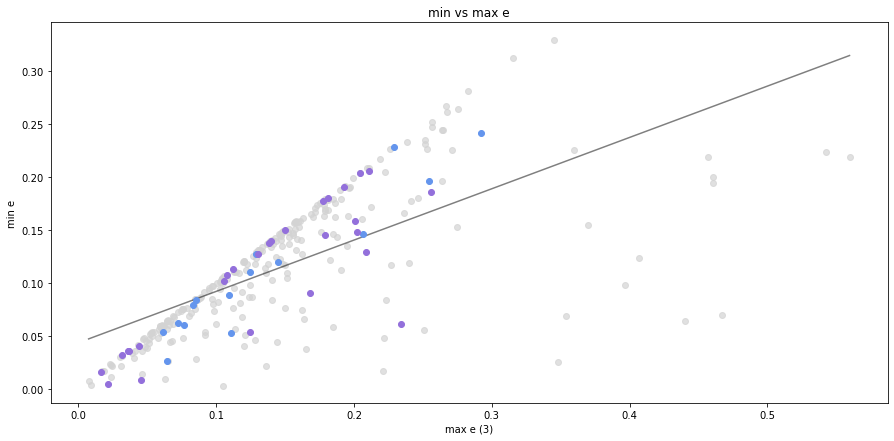

In [144]:
f=plt.figure(figsize=(15,7))

x = []
y = []

for i in range(0,len(features_test)):
    x.append(features_test[i][1])
    y.append(me[i])
    
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):    # is actually stable
            plt.scatter(features_test[i][1], me[i], color = 'mediumpurple', zorder = 5)
        else:  # is actually unstable
            plt.scatter(features_test[i][1], me[i], color = 'cornflowerblue', zorder = 5)
    else:
        plt.scatter(features_test[i][1], me[i], color = 'lightgray', alpha=0.7)
       

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha = 0.5)

        
# plt.ylim(-0.25, 1)        
plt.xlabel('max e (3)')
plt.ylabel('min e')
plt.title('min vs max e')

###### probability - stable/unstable

In [151]:
# certainity/probability for misclassified ones, average percentage

r = classifier.predict_proba(features_test)   # col 0 = stable, 1 = unstable
m = []

print('Misclassified objects - unstable/stable probabilities: \n')
for i in range(0,len(r)):
    if (classes_test[i] != classes_predict[i]):
        print('Stable: ' + str(r[i][0]) + '. Unstable: ' + str(r[i][1]))
        if (classes_test[i] == 0):
            # print('Predicted: unstable. Actual: stable \n')
            m.append(r[i][0])
        else:
            # print('Predicted: stable. Actual: unstable \n')
            m.append(r[i][1])
            
print('\nAverage probability for misclassified objects: ' + str(np.mean(m)))

Misclassified objects - unstable/stable probabilities: 

Stable: 0.4073492093527856. Unstable: 0.5926507906472144
Stable: 0.6973643123176625. Unstable: 0.30263568768233745
Stable: 0.282228968658355. Unstable: 0.717771031341645
Stable: 0.22987919591977923. Unstable: 0.7701208040802208
Stable: 0.08381515181597143. Unstable: 0.9161848481840286
Stable: 0.06120588444795738. Unstable: 0.9387941155520426
Stable: 0.10893113536410104. Unstable: 0.891068864635899
Stable: 0.6017241571501935. Unstable: 0.3982758428498065
Stable: 0.3268899893719128. Unstable: 0.6731100106280872
Stable: 0.7992941012575148. Unstable: 0.20070589874248518
Stable: 0.7582993918377426. Unstable: 0.24170060816225733
Stable: 0.7614745761976213. Unstable: 0.23852542380237873
Stable: 0.10868679976287943. Unstable: 0.8913132002371206
Stable: 0.12995045951169726. Unstable: 0.8700495404883027
Stable: 0.08953576128622842. Unstable: 0.9104642387137716
Stable: 0.9320779529520534. Unstable: 0.06792204704794658
Stable: 0.558389942667

In [177]:
# certainity/probability for misclassified ones, average percentage

r = classifier.predict_proba(features_test)   # col 0 = stable, 1 = unstable
m = []
acs = []
acu = []

cu = 0    # count actually unstable//actually stable
cs = 0

print('Misclassified planets: \n')

for i in range(0,len(r)):
    if (classes_test[i] != classes_predict[i]):
#         print('Run ' + str(ru[i]) + ', Planet ' + str(p[i]))
        if (classes_predict[i] == 0):
            print('Probability - ' + str(r[i][0] * 100) + '\nPredicted stable, actually unstable')
            m.append(r[i][0] * 100)
            acu.append(r[i][0] * 100)
            cu += 1
        else:
            print('Probability - ' + str(r[i][1] * 100) + '\nPredicted unstable, actually stable')
            m.append(r[i][1] * 100)
            acs.append(r[i][1] * 100)
            cs += 1
            
        print('Instability Time: ' + str(e[i]) + '\n')
        
print('\nAverage probability for misclassified planets: ' + str(np.mean(m)))
print('\nAverage probability for planets predicted stable, actually unstable: ' + str(np.mean(acu)))
print('\nAverage probability for planets predicted unstable, actually stable: ' + str(np.mean(acs)))

print('\nNumber of misclassified planets predicted unstable, actually stable: ' + str(cs))
print('Number of misclassified planets predicted stable, actually unstable: ' + str(cu))

Misclassified planets: 

Probability - 59.26507906472144
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 69.73643123176625
Predicted stable, actually unstable
Instability Time: 118928.0515615

Probability - 71.7771031341645
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 77.01208040802207
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 91.61848481840286
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 93.87941155520426
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 89.1068864635899
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 60.17241571501935
Predicted stable, actually unstable
Instability Time: 19753.175330000002

Probability - 67.31100106280871
Predicted unstable, actually stable
Instability Time: 10000000.0

Probability - 79.92941012575147
Predicted stable, actually unstable
Instability Tim

In [159]:
# certainity/probability for correctly classified planets, average percentage

r = classifier.predict_proba(features_test) 
m = []
s = []
u = []

print('Probabilities for correctly classified planets: \n')
for i in range(0,len(r)):
    if (classes_test[i] == classes_predict[i]):
        if (classes_test[i] == 0):
            print(str(r[i][0] * 100) + ' - stable')
            m.append(r[i][0] * 100)
            s.append(r[i][0] * 100)
        else:
            print(str(r[i][1] * 100) + ' - unstable')
            m.append(r[i][1] * 100)
            u.append(r[i][1] * 100)
            
print('\nAverage probability for correctly classified objects: ' + str(np.mean(m)))
print('\nAverage probability for planets correctly classified as stable: ' + str(np.mean(s)))
print('\nAverage probability for planets correctly classified as unstable: ' + str(np.mean(u)))

Probabilities for correctly classified planets: 

92.10448376108775 - unstable
65.28733482597637 - stable
68.92584117780076 - stable
61.17174577256223 - stable
92.56029752462798 - unstable
90.13958581777348 - unstable
92.83086259099646 - unstable
95.68390223662522 - unstable
82.9791115875801 - unstable
78.95513988875886 - unstable
94.37793866520933 - unstable
83.04684393121013 - stable
88.38045081498112 - unstable
95.3882499091582 - unstable
75.85310313648137 - unstable
52.615048171546384 - stable
95.67232920487068 - unstable
96.03211196099451 - unstable
81.55527997762519 - unstable
91.69458157076468 - unstable
90.04488929362937 - stable
95.22874417889284 - unstable
95.39256093589961 - unstable
59.33637595500275 - stable
91.62401241613682 - unstable
85.9018704210639 - stable
79.08729316166941 - unstable
82.1636550893308 - unstable
80.76127957772259 - stable
92.91738405042081 - unstable
91.94293839066091 - unstable
91.18324523674883 - stable
95.57368034903523 - unstable
96.0872946166702

In [170]:
# distribution of probabilities

r = classifier.predict_proba(features_test) 
n = 0
n90 = 0
n95 = 0
n99 = 0

for i in range(0,len(r)):
    if (classes_test[i] == classes_predict[i]):
        n += 1
        if (classes_test[i] == 0):
            if ((r[i][0] * 100) > 90):
                n90 += 1
                if ((r[i][0] * 100) > 95):
                    n95 += 1
                    if ((r[i][0] * 100) > 99):
                        n99 += 1
            
        else:
            if ((r[i][1] * 100) > 90):
                n90 += 1
                if ((r[i][1] * 100) > 95):
                    n95 += 1
                    if ((r[i][1] * 100) > 99):
                        n99 += 1

print('Sample size: ' + str(len(r)))
print('\nNumber of correctly classified planets: ' + str(n))
print('\nCorrectly classified planets with probability >90%: ' + str(n90))
print('\nCorrectly classified planets with probability >95%: ' + str(n95))
print('\nCorrectly classified planets with probability >99%: ' + str(n99))

Sample size: 300

Number of correctly classified planets: 258

Correctly classified planets with probability >90%: 129

Correctly classified planets with probability >95%: 43

Correctly classified planets with probability >99%: 0


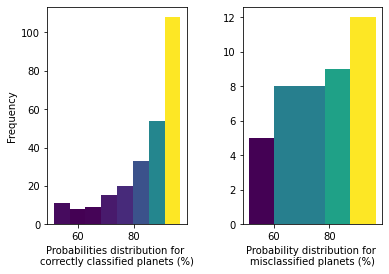

In [163]:
# histogram

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

fig, (ax1, ax2) = plt.subplots(1, 2)

c = []
w = []


# correct
inds = []

for i in range(0,len(classes_test)):
    if (classes_test[i] == classes_predict[i]):   # 0 = stable, 1 = unstable
        inds.append(i)

r = classifier.predict_proba(features_test)

for i in range(0,len(r)):
    if (classes_test[i] == classes_predict[i]):
        if (classes_test[i] == 0):
            c.append(r[i][0]*100)
        else:
            c.append(r[i][1]*100)
            
            
# wrong
inds2 = []

r2 = classifier.predict_proba(features_test)   # col 1 = stable

for i in range(0,len(classes_test)):
    if (classes_test[i] != classes_predict[i]):   # 0 = stable, 1 = unstable
        inds2.append(i)

for i in range(0,len(r2)):
    if (classes_test[i] != classes_predict[i]):
        if (classes_test[i] == 0):
            w.append(r2[i][1]*100)
        else:
            w.append(r2[i][0]*100)
            
            
plt.subplot(1, 2, 1)
N, bins, patches = plt.hist(c, bins = 8)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Probabilities distribution for \ncorrectly classified planets (%)')
plt.ylabel('Frequency')
# plt.ylim(0,200)
# plt.xlim(50,100)


plt.subplot(1, 2, 2)
N, bins, patches = plt.hist(w, bins = 5)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel('Probability distribution for \nmisclassified planets (%)') 
# plt.ylim(0,200)
# plt.xlim(50,100)

plt.subplots_adjust(wspace=0.4)
plt.show()

Text(0.5, 1.0, 'Unstable planets - probability vs instability time')

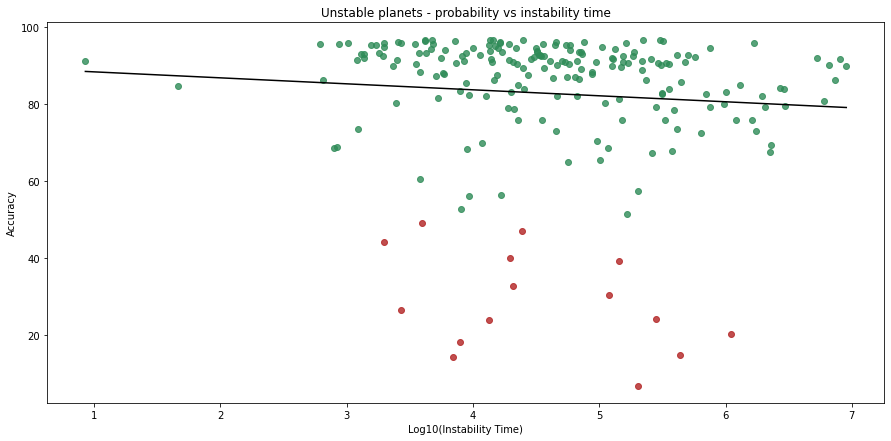

In [145]:
prob = []
inst = []


f=plt.figure(figsize=(15,7))

for i in range(0,len(r)):
    if (classes_test[i] == 1):
        prob.append(r[i][1] * 100)
        inst.append(np.log10(e[i]))
        
        if (classes_predict[i] == 1):
            plt.scatter(np.log10(e[i]), r[i][1] * 100, color = 'seagreen', alpha = 0.8)
        elif (classes_predict[i] == 0):
            plt.scatter(np.log10(e[i]), r[i][1] * 100, color = 'firebrick', alpha = 0.8)

            
plt.plot(np.unique(inst), np.poly1d(np.polyfit(inst, prob, 1))(np.unique(inst)), color='black')
            

plt.ylabel('Accuracy')
plt.xlabel('Log10(Instability Time)')
plt.title('Unstable planets - probability vs instability time')

Text(0.5, 1.0, 'Unstable planets - probability vs instability time')

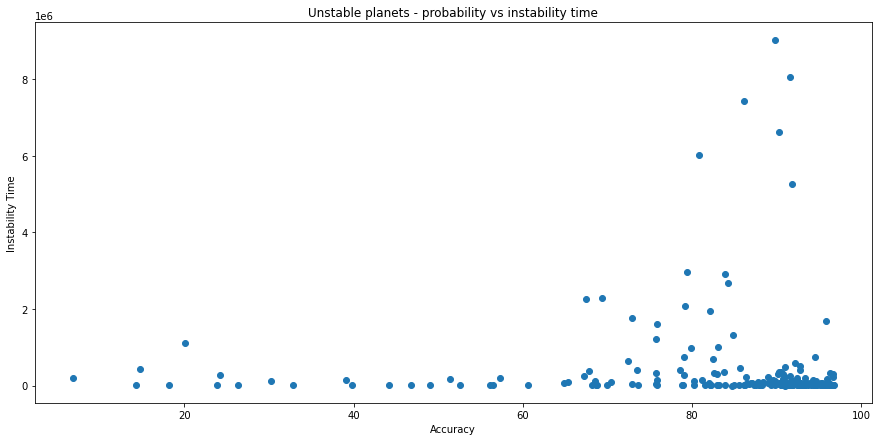

In [96]:
prob = []
inst = []

    
f=plt.figure(figsize=(15,7))

for i in range(0,len(classes_test)):
    if (classes_test[i] == 1):
        prob.append(r[i][1] * 100)
        inst.append(e[i])
            
            
plt.scatter(prob, inst, marker = 'o')

plt.xlabel('Accuracy')
plt.ylabel('Instability Time')
plt.title('Unstable planets - probability vs instability time')